In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from PIL import Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import scipy.ndimage
import scipy.misc
%matplotlib inline
import h5py
import gc
import time

In [2]:
dataset_location = '/Users/himanshubabal/Documents/External_Disk_Link_WD_HDD/Study/SVHN/SVHN-Full_Dataset/'

In [3]:
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [4]:
fin = os.path.join(dataset_location + 'test', 'digitStruct.mat')
dsf = DigitStructFile(fin)
test_data = dsf.getAllDigitStructure_ByDigit()

In [5]:
len(test_data)

13068

In [6]:
test_data[10]['boxes'][0]

{'height': 43.0, 'label': 3.0, 'left': 52.0, 'top': 9.0, 'width': 24.0}

In [7]:
def plot_img(image):
    plt.imshow(image)
    plt.show()

In [8]:
def get_img(j):

    folder_name = 'test'

    image = test_data[j]
    image_name = dataset_location + folder_name + '/' + image['filename']

    img = Image.open(image_name)
    img.load()
    img = np.asarray(img, dtype="float32")

    return img

In [9]:
import cv2

In [10]:
test_data[10]['boxes'][0]

{'height': 43.0, 'label': 3.0, 'left': 52.0, 'top': 9.0, 'width': 24.0}

In [11]:
# In -> tuple (x, x)
def limit_float(number):
    a = float("{0:.4f}".format(number[0]))
    b = float("{0:.4f}".format(number[1]))
    return(a, b)

155 69
(61, 30) (73, 52)
(0.3935, 0.4348) (0.471, 0.7536)

(74, 30) (85, 52)
(0.4774, 0.4348) (0.5484, 0.7536)

(85, 26) (97, 48)
(0.5484, 0.3768) (0.6258, 0.6957)

[{'width': 12.0, 'top': 30.0, 'label': 1.0, 'left': 61.0, 'height': 22.0}, {'width': 11.0, 'top': 30.0, 'label': 4.0, 'left': 74.0, 'height': 22.0}, {'width': 12.0, 'top': 26.0, 'label': 5.0, 'left': 85.0, 'height': 22.0}]


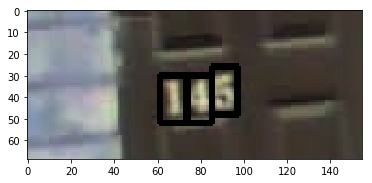

In [31]:
j = 12345

i = np.copy(get_img(j))

i_x = i.shape[1]
i_y = i.shape[0]
print(i_x, i_y)

x_list, y_list = list(), list()
for k in range(len(test_data[j]['boxes'])):
    i_1 = test_data[j]['boxes'][k]
    p1 = (int(i_1['left']), int(i_1['top']))
    p2 = (int(i_1['left']) + int(i_1['width']), int(i_1['top']) + int(i_1['height']))
    print(p1, p2)
    
    p1_new = limit_float((float(p1[0])/i_x, float(p1[1])/i_y))
    p2_new = limit_float((float(p2[0])/i_x, float(p2[1])/i_y))
    print(p1_new, p2_new)
    
    x_list.append(p1[0])
    x_list.append(p2[0])
    y_list.append(p1[1])
    y_list.append(p2[1])
    
    cv2.rectangle(i,p1,p2,(0,255,0),2)
    print('')

print(test_data[j]['boxes'])

p1 = (min(x_list), max(y_list))
p2 = (max(x_list), min(y_list))
# cv2.rectangle(i,p1,p2,(255,0,0),5)
plot_img(i)


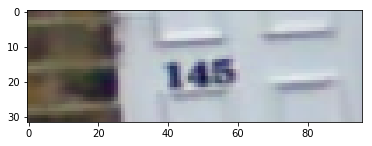

In [32]:
i = np.copy(get_img(j))
ir = scipy.misc.imresize(i, (32, 96))
plot_img(ir)

In [34]:
ir.shape

(32, 96, 3)

96 32
0.61935483871 0.463768115942
(37, 13) (44, 23)
(0.3854, 0.4062) (0.4583, 0.7188)

0.61935483871 0.463768115942
(45, 13) (51, 23)
(0.4688, 0.4062) (0.5312, 0.7188)

0.61935483871 0.463768115942
(52, 12) (59, 22)
(0.5417, 0.375) (0.6146, 0.6875)

[{'width': 12.0, 'top': 30.0, 'label': 1.0, 'left': 61.0, 'height': 22.0}, {'width': 11.0, 'top': 30.0, 'label': 4.0, 'left': 74.0, 'height': 22.0}, {'width': 12.0, 'top': 26.0, 'label': 5.0, 'left': 85.0, 'height': 22.0}]


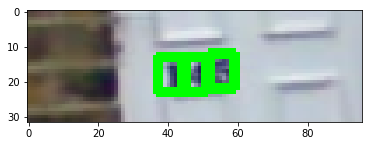

In [35]:
i = np.copy(ir)

i_x = i.shape[1]
i_y = i.shape[0]
print(i_x, i_y)

x_list, y_list = list(), list()
for k in range(len(test_data[j]['boxes'])):
    i_1 = test_data[j]['boxes'][k]

#     old_shape = (155, 69)
#     new_shape = (96, 32)
    old_shape = (get_img(j).shape[1]*1.0, get_img(j).shape[0]*1.0)
    new_shape = (i.shape[1]*1.0, i.shape[0]*1.0)
    
    x_mult = new_shape[0]/old_shape[0]
    y_mult = new_shape[1]/old_shape[1]
    print(x_mult, y_mult)
    
    p1 = (int(i_1['left'] * x_mult), int(i_1['top'] * y_mult))
    p2 = (int(i_1['left'] * x_mult) + int(i_1['width'] * x_mult), int(i_1['top'] * y_mult) + int(i_1['height'] * y_mult))
    print(p1, p2)
    
    
    p1_new = limit_float((float(p1[0])/i_x, float(p1[1])/i_y))
    p2_new = limit_float((float(p2[0])/i_x, float(p2[1])/i_y))
    print(p1_new, p2_new)
    
    x_list.append(p1[0])
    x_list.append(p2[0])
    y_list.append(p1[1])
    y_list.append(p2[1])
    
    cv2.rectangle(i,p1,p2,(0,255,0),2)
    print('')

print(test_data[j]['boxes'])

p1 = (min(x_list), max(y_list))
p2 = (max(x_list), min(y_list))
# cv2.rectangle(i,p1,p2,(255,0,0),5)
plot_img(i)

In [13]:
l = len(test_data)
l = 100

test_images = np.ndarray([l, 32, 96, 1], dtype='float32')
test_labels = np.ndarray([l, 6], dtype='int32')
test_boxes = np.ndarray([l, 24], dtype='float32')

no_img_points = [0.1, 0.1, 1.1, 1.1]

folder_name = 'test'

for i in range(l) :
    image = test_data[i]
    image_name = dataset_location + folder_name + '/' + image['filename']
    
    img = Image.open(image_name)
    img.load()
    img = np.asarray(img, dtype="float32")
    
    img_box = np.copy(img)
    
    # Resizing Image to be of 32x96x3 dimensions
    img = scipy.misc.imresize(img, (32, 96))
    # Converting A x B x 3 -> A x B x 1
    img = np.dot(img, [[0.2989],[0.5870],[0.1140]])
    
    # Mean and Std Deviation of Image
    mean = np.mean(img, dtype='float32')
    std = np.std(img, dtype='float32', ddof=1)
    if std < 1e-4:
        std = 1.0
    # Normalizing the image
    im = (img - mean)/std
    
    # Finding No of Digits in given image
    no_of_digits = len(image['boxes'])
    # If no of digits is > 5
    # Leave this example out, as we don't need it
    # Continue to next Iteration
    if no_of_digits > 5:
        print('more then 5 digits', image['boxes'])
        continue

    # Numpy Array 'dig' will contain digits in the format :
    # [No_of_digits, _, _, _, _, _]
    dig = np.array([])
    dig = np.append(dig, no_of_digits)
    
    for j in range(no_of_digits) :
        digit = image['boxes'][j]['label']
        dig = np.append(dig, digit)
    
    # Appending '0' to represent Empty Space
    zeros = 5 - no_of_digits
    for z in range(zeros) :
        dig = np.append(dig, 0)
        
    test_images[i,:,:,:] = im[:,:,:]
    test_labels[i,:] = dig
    
    # Bounding Boxes
    print(img_box.shape)
    bbox = np.array([])
    i_x, i_y = img_box.shape[1], img_box.shape[0]
    x_list, y_list = list(), list()
    # Store in order [x11, y11, x12, y12,   x21, y21, x22, y22,   x31, y31, x32, y32, ..... upto 5 images]
    points_list = []
    
    for k in range(len(image['boxes'])):
        i_1 = image['boxes'][k]
        print(i_1)
        p1 = (int(i_1['left']), int(i_1['top']))
        p2 = (int(i_1['left']) + int(i_1['width']), int(i_1['top']) + int(i_1['height']))
        print(p1, p2)
        p1_new = limit_float((float(p1[0])/i_x, float(p1[1])/i_y))
        p2_new = limit_float((float(p2[0])/i_x, float(p2[1])/i_y))
        
        print(p1_new, p2_new)

        x_list.append(p1_new[0])
        x_list.append(p2_new[0])
        y_list.append(p1_new[1])
        y_list.append(p2_new[1])
        
        points_list.append(p1_new[0])
        points_list.append(p1_new[1])
        points_list.append(p2_new[0])
        points_list.append(p2_new[1])

    
    

    p1 = (min(x_list), max(y_list))
    p2 = (max(x_list), min(y_list))
    bbox = np.append(bbox, [p1[0], p1[1], p2[0], p2[1]])
    
    bbox = np.append(bbox, points_list)
    
    zeros = 5 - no_of_digits
    for z in range(zeros) :
        bbox = np.append(bbox, no_img_points)
        
    test_boxes[i,:] = bbox
    print(bbox)
    
    if i % 1500 == 0:
        print((i/l)*100)
        

(47, 99, 3)
{'width': 19.0, 'top': 7.0, 'label': 5.0, 'left': 43.0, 'height': 30.0}
(43, 7) (62, 37)
(0.4343, 0.1489) (0.6263, 0.7872)
[ 0.4343  0.7872  0.6263  0.1489  0.4343  0.1489  0.6263  0.7872  0.1     0.1
  1.1     1.1     0.1     0.1     1.1     1.1     0.1     0.1     1.1     1.1
  0.1     0.1     1.1     1.1   ]
0
(48, 182, 3)
{'width': 14.0, 'top': 5.0, 'label': 2.0, 'left': 99.0, 'height': 23.0}
(99, 5) (113, 28)
(0.544, 0.1042) (0.6209, 0.5833)
{'width': 8.0, 'top': 8.0, 'label': 1.0, 'left': 114.0, 'height': 23.0}
(114, 8) (122, 31)
(0.6264, 0.1667) (0.6703, 0.6458)
{'width': 12.0, 'top': 6.0, 'label': 10.0, 'left': 121.0, 'height': 23.0}
(121, 6) (133, 29)
(0.6648, 0.125) (0.7308, 0.6042)
[ 0.544   0.6458  0.7308  0.1042  0.544   0.1042  0.6209  0.5833  0.6264
  0.1667  0.6703  0.6458  0.6648  0.125   0.7308  0.6042  0.1     0.1     1.1
  1.1     0.1     0.1     1.1     1.1   ]
(31, 101, 3)
{'width': 11.0, 'top': 6.0, 'label': 6.0, 'left': 61.0, 'height': 16.0}
(61, 6) 

In [14]:
test_labels

array([[ 1,  5,  0,  0,  0,  0],
       [ 3,  2,  1, 10,  0,  0],
       [ 1,  6,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0],
       [ 1,  9,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0],
       [ 3,  1,  8,  3,  0,  0],
       [ 2,  6,  5,  0,  0,  0],
       [ 3,  1,  4,  4,  0,  0],
       [ 2,  1,  6,  0,  0,  0],
       [ 2,  3,  4,  0,  0,  0],
       [ 2,  2, 10,  0,  0,  0],
       [ 2,  1,  3,  0,  0,  0],
       [ 2,  2,  5,  0,  0,  0],
       [ 1,  4,  0,  0,  0,  0],
       [ 2,  1,  4,  0,  0,  0],
       [ 2,  2,  8,  0,  0,  0],
       [ 2,  3,  8,  0,  0,  0],
       [ 2,  6, 10,  0,  0,  0],
       [ 3,  1,  5,  1,  0,  0],
       [ 3,  1,  2,  9,  0,  0],
       [ 2,  1,  6,  0,  0,  0],
       [ 1,  9,  0,  0,  0,  0],
       [ 2,  2,  6,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0],
       [ 2,  2, 10,  0,  0,  0],
       [ 2,  6,  9,  0,  0,  0],
       [ 2,  1,  5,  0,  0,  0],
       [ 2,  1,  9,  0,  0,  0],
       [ 2,  8,  1,  0,  0,  0],
       [ 2

In [15]:
test_boxes[43]

array([ 0.37889999,  0.7568    ,  0.71579999,  0.2703    ,  0.37889999,
        0.35139999,  0.4526    ,  0.7568    ,  0.44209999,  0.2703    ,
        0.53680003,  0.67570001,  0.5158    ,  0.29730001,  0.61049998,
        0.70270002,  0.60000002,  0.29730001,  0.71579999,  0.70270002,
        0.1       ,  0.1       ,  1.10000002,  1.10000002], dtype=float32)

In [16]:
test_images.shape

(100, 32, 96, 1)

In [17]:
for i in range(0, 24, 4):
    a = test_boxes[43][i] * 96
    b = test_boxes[43][i+1] * 32
    c = test_boxes[43][i+2] * 96
    d = test_boxes[43][i+3] * 32
    
    print((a, b), (c, d))

(36.374399185180664, 24.217599868774414) (68.716798782348633, 8.6496000289916992)
(36.374399185180664, 11.244799613952637) (43.449600219726562, 24.217599868774414)
(42.441598892211914, 8.6496000289916992) (51.532802581787109, 21.622400283813477)
(49.516799926757812, 9.5136003494262695) (58.607997894287109, 22.486400604248047)
(57.600002288818359, 9.5136003494262695) (68.716798782348633, 22.486400604248047)
(9.6000001430511475, 3.2000000476837158) (105.60000228881836, 35.200000762939453)


In [18]:
l = 43

ii = test_images[l]
print(test_labels[l])

# for s in range(99):
#     print(s, test_labels[s])

[4 1 7 1 2 0]








(32, 96)


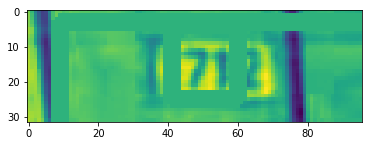

In [19]:
iii = np.copy(ii)

for i in range(0, 24, 4):
    a = test_boxes[0][i] * 96
    b = test_boxes[0][i+1] * 32
    c = test_boxes[0][i+2] * 96
    d = test_boxes[0][i+3] * 32

    p1 = (int(a), int(b))
    p2 = (int(c), int(d))
    
    cv2.rectangle(iii,p1,p2,(0,255,0),3)
    print('')

print(iii[:,:,0].shape)
plt.imshow(iii[:,:,0])
plt.show()